In [22]:
pip install gymnasium

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Polygon

class SokobanEnvironment:
    def __init__(self):
        self.grid = [
            [1, 1, 1, 1, 1, 1],
            [1, 0, 0, 1, 1, 1],
            [1, 0, 0, 1, 1, 1],
            [1, 3, 0, 0, 0, 1],
            [1, 0, 0, 2, 0, 1],
            [1, 0, 0, 1, 1, 1],
            [1, 1, 1, 1, 1, 1],
        ]
        self.agent_position = (1, 2)
        self.box_positions = [(4, 3)]
        self.storage_positions = [(3, 1)]
        self.actions = {
            "UP": (-1, 0),
            "DOWN": (1, 0),
            "LEFT": (0, -1),
            "RIGHT": (0, 1)
        }
        self.done = False

    def display_grid(self):
        """Graphical display of the grid with a new color scheme and shapes."""
        fig, ax = plt.subplots()

        for row in range(len(self.grid)):
            for col in range(len(self.grid[row])):
                if self.grid[row][col] == 1:
                    ax.add_patch(Rectangle((col, row), 1, 1, edgecolor='black', facecolor='lightgray'))
                elif (row, col) == self.agent_position:
                    ax.add_patch(Circle((col + 0.5, row + 0.5), 0.4, edgecolor='black', facecolor='green'))
                elif (row, col) in self.box_positions:
                    ax.add_patch(Rectangle((col, row), 1, 1, edgecolor='black', facecolor='purple'))
                    ax.plot([col, col + 1], [row, row + 1], color='white')
                    ax.plot([col, col + 1], [row + 1, row], color='white')
                elif (row, col) in self.storage_positions:
                    diamond = Polygon([[col + 0.5, row], [col + 1, row + 0.5], [col + 0.5, row + 1], [col, row + 0.5]],
                                      edgecolor='black', facecolor='cyan')
                    ax.add_patch(diamond)
                else:
                    ax.add_patch(Rectangle((col, row), 1, 1, edgecolor='black', facecolor='beige'))

        ax.set_xlim(0, len(self.grid[0]))
        ax.set_ylim(0, len(self.grid))
        ax.set_aspect('equal')
        plt.gca().invert_yaxis()  # Keeping the origin at the top-left for visual consistency
        plt.axis('off')  # Removing axes for a cleaner look
        plt.show()

    def reset(self):
        self.agent_position = (1, 2)
        self.box_positions = [(4, 3)]
        self.done = False

    def get_next_state(self, action):
        dx, dy = action
        x, y = self.agent_position
        next_agent_position = (x + dx, y + dy)

        if self.is_valid_position(next_agent_position):
            if next_agent_position in self.box_positions:
                next_box_position = (next_agent_position[0] + dx, next_agent_position[1] + dy)
                if self.is_valid_position(next_box_position) and next_box_position not in self.box_positions:
                    self.box_positions.remove(next_agent_position)
                    self.box_positions.append(next_box_position)
                    return next_agent_position
                else:
                    return self.agent_position
            else:
                return next_agent_position
        else:
            return self.agent_position

    def is_valid_position(self, position):
        x, y = position
        if x < 0 or x >= len(self.grid) or y < 0 or y >= len(self.grid[0]):
            return False
        if self.grid[x][y] == 1:
            return False
        return True

    def step(self, action):
        if self.done:
            return self.agent_position, 0, self.done


        previous_agent_position = self.agent_position
        self.agent_position = self.get_next_state(self.actions[action])


        if self.agent_position != previous_agent_position:

            if previous_agent_position in self.box_positions:
                box_index = self.box_positions.index(previous_agent_position)
                if self.box_positions[box_index] in self.storage_positions:
                    reward = 5
                else:
                    reward = -1
            else:
                reward = -1

            if all(box in self.storage_positions for box in self.box_positions):
                print("All boxes are placed in storage! Episode complete.")
                self.done = True

            for box in self.box_positions:
                if self.is_box_stuck(box):
                    print("A box is stuck! Episode complete.")
                    self.done = True
        else:
            if not self.is_valid_position(self.agent_position):
                reward = -10
            else:
                reward = -1

        return self.agent_position, reward, self.done

    def is_box_stuck(self, box_position):
        x, y = box_position
        if (self.grid[x-1][y] == 1 and self.grid[x][y-1] == 1) or \
           (self.grid[x-1][y] == 1 and self.grid[x][y+1] == 1) or \
           (self.grid[x+1][y] == 1 and self.grid[x][y-1] == 1) or \
           (self.grid[x+1][y] == 1 and self.grid[x][y+1] == 1):
            return True
        return False

In [47]:
import random
from collections import defaultdict

class SokobanAgent:
    def __init__(self, env):
        self.env = env
        self.value_function = defaultdict(float)
        self.policy = {state: random.choice(list(env.actions.keys())) for state in self.get_all_states()}
        self.discount_factor = 0.9
        self.alpha = 0.1
        self.epsilon = 0.3

    def value_iteration(self, theta=1e-5):
        while True:
            delta = 0
            for state in self.get_all_states():
                v = self.value_function[state]
                self.value_function[state] = max(self.calculate_q_value(state, action) for action in self.env.actions.keys())
                delta = max(delta, abs(v - self.value_function[state]))
            if delta < theta:
                break

        self.extract_optimal_policy()

    def calculate_q_value(self, state, action):
        total = 0
        for next_action in self.env.actions.keys():
            next_state, reward, _ = self.simulate_action(state, action)
            total += (1 / len(self.env.actions)) * (reward + self.discount_factor * self.value_function[next_state])
        return total

    def simulate_action(self, state, action):
        x, y = state
        dx, dy = self.env.actions[action]
        next_agent_position = (x + dx, y + dy)

        if self.env.is_valid_position(next_agent_position):
            if next_agent_position in self.env.box_positions:
                next_box_position = (next_agent_position[0] + dx, next_agent_position[1] + dy)
                if self.env.is_valid_position(next_box_position) and next_box_position not in self.env.box_positions:
                    next_agent_position = next_box_position
                    return next_agent_position, 5, False
            return next_agent_position, -1, False
        return state, -10, False

    def get_all_states(self):
        states = []
        for x in range(len(self.env.grid)):
            for y in range(len(self.env.grid[0])):
                states.append((x, y))
        return states

    def extract_optimal_policy(self):
        for state in self.get_all_states():
            if state in self.value_function:
                self.policy[state] = max(self.env.actions.keys(), key=lambda action: self.calculate_q_value(state, action))

    def monte_carlo_control(self, num_episodes):
        returns = defaultdict(list)
        for episode_num in range(num_episodes):
            episode_data = self.generate_episode()
            visited_states = set()
            G = 0

            for state, action, reward in reversed(episode_data):
                G = reward + self.discount_factor * G
                if state not in visited_states:
                    returns[(state, action)].append(G)
                    self.value_function[state] = np.mean(returns[(state, action)])
                    visited_states.add(state)
            self.extract_optimal_policy()

    def generate_episode(self):
        episode = []
        state = self.env.agent_position
        done = False

        while not done:
            if state in self.policy:
                if random.random() < self.epsilon:
                    action = random.choice(list(self.env.actions.keys()))
                else:
                    action = self.policy[state]
            else:
                action = random.choice(list(self.env.actions.keys()))

            next_state, reward, done = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

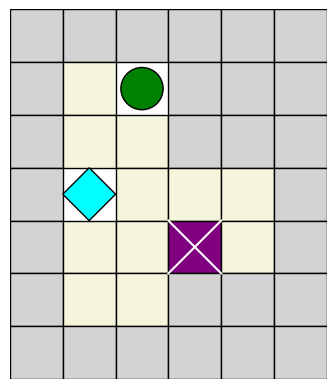

Value Function after Value Iteration:
State           Value          
------------------------------
(0, 0)          -99.99992      
(0, 1)          25.42940       
(1, 1)          29.36600       
(0, 2)          29.36600       
(1, 2)          33.74000       
(0, 3)          -99.99992      
(0, 4)          -99.99992      
(0, 5)          -99.99992      
(1, 0)          25.42940       
(2, 1)          33.74000       
(2, 2)          38.60000       
(1, 3)          29.36600       
(1, 4)          -99.99992      
(1, 5)          -99.99992      
(2, 0)          29.36600       
(3, 1)          38.60000       
(3, 2)          44.00000       
(2, 3)          33.74000       
(3, 3)          38.60000       
(2, 4)          38.60000       
(3, 4)          44.00000       
(2, 5)          -99.99992      
(3, 0)          33.74000       
(4, 1)          44.00000       
(4, 2)          50.00000       
(4, 3)          44.00000       
(4, 4)          50.00000       
(3, 5)          38.60000       
(4,

In [48]:
def main():
    env = SokobanEnvironment()
    env.display_grid()

    agent_dp = SokobanAgent(env)
    agent_dp.value_iteration()
    print("Value Function after Value Iteration:")
    print("{:<15} {:<15}".format("State", "Value"))
    print("-" * 30)
    for state, value in agent_dp.value_function.items():
        print(f"{str(state):<15} {value:<15.5f}")

    print("\nOptimal Policy after Value Iteration:")
    print("{:<15} {:<15}".format("State", "Optimal Action"))
    print("-" * 30)
    for state, action in agent_dp.policy.items():
        print(f"{str(state):<15} {action:<15}")

    env.reset()

    agent_mc = SokobanAgent(env)
    agent_mc.monte_carlo_control(num_episodes=1000)
    print("\nValue Function after Monte Carlo Control:")
    print("{:<15} {:<15}".format("State", "Value"))
    print("-" * 30)
    for state, value in agent_mc.value_function.items():
        print(f"{str(state):<15} {value:<15.5f}")

    print("\nOptimal Policy after Monte Carlo Control:")
    print("{:<15} {:<15}".format("State", "Optimal Action"))
    print("-" * 30)
    for state, action in agent_mc.policy.items():
        print(f"{str(state):<15} {action:<15}")

if __name__ == "__main__":
    main()